本篇主要参考  
- `Efficient Parallelization of a Ubiquitous Sequential Computation`  
- `Were RNNs All We Needed?`  
- [并行扫描博客1](https://moreality.net/posts/54261/)
- [并行扫描博客2](https://fancyerii.github.io/pmpp/ch11/)
- [相关文献解读博客](https://blog.csdn.net/weixin_40779727/article/details/143960241)
- [NV并行扫描](https://developer.nvidia.com/gpugems/gpugems3/part-vi-gpu-computing/chapter-39-parallel-prefix-sum-scan-cuda)

兼作实现和探究  


# 1.并行扫描（前缀扫描）问题

对于如下前缀和问题
```shell
# input:
[a0, a1, a2, a3, ..., an]

# output:
[a0, (a0+a1), (a0+a1+a2), ..., (a0+a1+a2+...+an)]
```
可以写出递推关系式
$$
x_{t} = x_{t-1} + b_{t}\ \ \ \ \ (x_0 = b_0)
$$

## 1.1 顺序计算

根据递推关系，顺序计算方法如下

In [4]:
def inclusive_scan_recursive(lst_i):
    n = len(lst_i)
    lst_o = lst_i
    for i in range(1,n):
        lst_o[i] = lst_o[i-1] + lst_i[i]
    return lst_o

可以得到时间复杂度是$O(n)$   
需要进行<font color=red font size=5>**n-1**</font>次运算

## 1.2 Blelloch并行扫描

而高效的并行前缀和的算法是Blelloch的算法（有的地方叫Brent-Kung算法），运算的示意图如下  
先是**Up-sweep**过程  
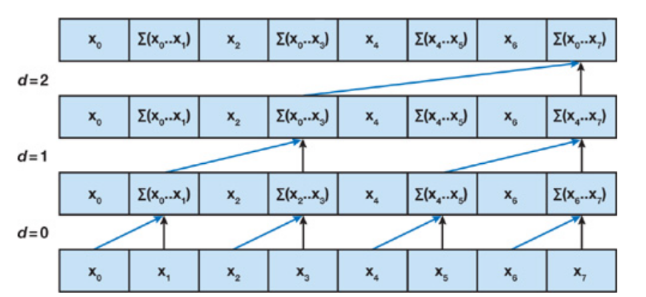  
接下来是**Down-sweep**过程  
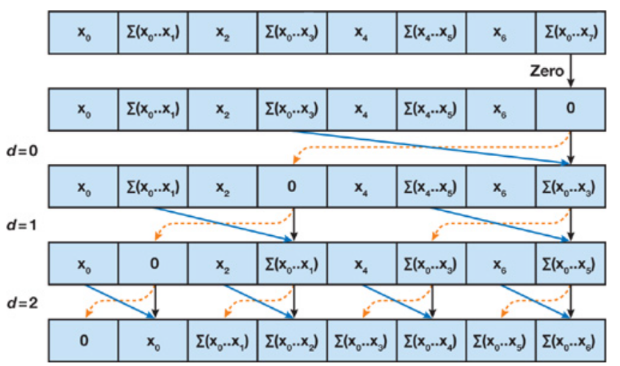  
另一种图示如下  
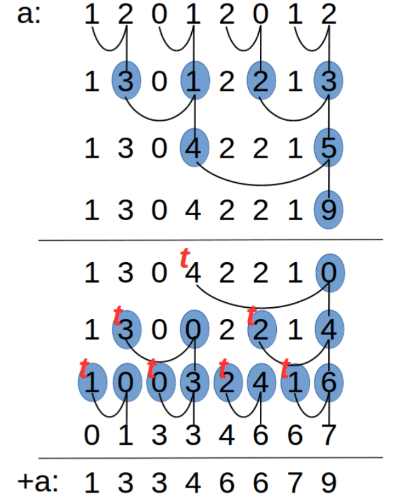

如果考虑每行的运算是一个时刻，那么其时间复杂度是$O(logn)$  
其中Up-sweep和Down-sweep都是$O(logn)$   
可以看到提速相比顺序计算的$O(n)$还是很高的
计算次数按照下面的公式得到
$$
(1+2+4+...+n/2)*2 = (1+2+4+...+n) -1 = 2(n-1)
$$
所以计算次数是<font color=red font size=5>**2(n-1)**</font>,是顺序算法的2倍

## 1.3 一些权衡

看起来并行扫描的优势很大  
但这是建立在并行扫描<u>**每次迭代**</u>（如下图所示，每一行到下一行的变换）<u>**是一次性完成的**</u>这样一个假设之上的
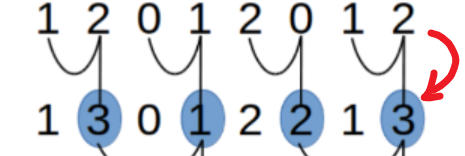

然而我们考虑硬件适配性（需要多少硬件计算单元），得到下面这样一张表

<table>
  <tr>
    <th>算法</th>
    <th>消耗时间</th>
    <th>计算次数</th>
    <th>硬件资源(Adder)</th>
  </tr>
  <tr>
    <td>顺序计算</td>
    <td>n</td>
    <td>n-1</td>
    <td>1</td>      
  </tr>
  <tr>
    <td>纯并行扫描</td>
    <td>$2\cdot log_2n$</td>
    <td>2(n-1)</td>
    <td>n/2</td>
  </tr>
</table>

我们以n=256为例   
顺序计算方法耗费时间为<font color=red font size=5>**256**</font>，计算次数为<font color=red font size=5>**255**</font>，硬件资源只需要<font color=red font size=5>**1**</font>个加法器    
而并行扫描耗费时间为<font color=red font size=5>**16**</font>，计算次数为<font color=red font size=5>**510**</font>，硬件资源需要<font color=red font size=5>**128**</font>个加法器

这消耗了过多的加法器，可以考虑一些权衡的方法，例如我们把每一行到下一行的变换，不在一个周期内完成。  
例如我们只有8个加法器，那么在图上的up-sweep第一行计算需要分为$256/8 = 32$个周期完成。我们可以用以下代码定量计算一下改良后的并行扫描。  
注意，**对并行扫描进行加法器复用的改良，不会改变计算次数。只会通过增减耗费时间来减少加法器的使用**   
因为改良的并行扫描不能直接给出公式，我们给出下面的代码进行计算    
我们将结果绘制成曲线，并绘制出顺序计算和纯并行的方案作为对比（图上红点）    
加法器越少越优，总计算时间越少越优

In [93]:
import math
#给出序列长度，返回不同adder_num下的计算时间
def parallel_scan_v2_property(n=256):
    calc_times_lst = []
    step = n//2
    while(step>=1):
        calc_times_lst.append(step)
        step //= 2
    print(f'down-sweep/up-sweep 每一行需要的计算次数：\n\33[1;7;32m{calc_times_lst}\33[0m')
    print('-'*50)
    
    result =[]
    for adder_num in range(1,n//2+1):
        line_times = []
        for line_calc_times in calc_times_lst:
            if(adder_num>=line_calc_times):
                line_times.append(1)
            else:
                line_times.append(math.ceil(line_calc_times/adder_num))
        total_times = 2*sum(line_times)
        result.append((adder_num,total_times))
        print(f'加法器数:\n\33[7;1m{adder_num}\33[0m')
        print(f'每行的计算周期:\n\33[7;1m{line_times}\33[0m')
        print(f'总计算周期（两倍down-sweep/up-sweep）:\n\33[7;1m{total_times}\33[0m')
        print('-'*50)
    return result 

In [98]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
def show_relation(n,result):
    # 分离数据
    x_values = [item[0] for item in result]
    y_values = [item[1] for item in result]
    serial_ref = (1,n-1)
    parallel_ref = (x_values[-1],y_values[-1])
    # 绘制散点图
    plt.figure(figsize=(2, 2))
    plt.plot(x_values, y_values,color='green',lw=1)
    plt.scatter(serial_ref[0], serial_ref[1], color='red',s=20)
    plt.scatter(parallel_ref[0], parallel_ref[1], color='red',s=20)
    plt.title(f'outline:n={n}')
    plt.xlabel('adder_num')
    plt.ylabel('total_calc_times')
    # 添加方框
    plt.plot([1, 20], [y_values[1], y_values[1]], color='black', lw=1)  # 上边界
    plt.plot([1, 20], [y_values[20], y_values[20]], color='black', lw=1)  # 下边界
    plt.plot([1, 1], [y_values[1], y_values[20]], color='black', lw=1)  
    plt.plot([20, 20], [y_values[1], y_values[20]], color='black', lw=1)  
    plt.grid(True)
    
    plt.figure(figsize=(3, 5))
    plt.plot(x_values, y_values,color='green',lw=2)
    plt.scatter(x_values, y_values, color='black',s=6)
    plt.scatter(serial_ref[0], serial_ref[1], color='red',s=20)
    plt.scatter(parallel_ref[0], parallel_ref[1], color='red',s=20)
    plt.title(f'Relation of adder_num with total_calc_times:n={n}')
    plt.xlabel('adder_num')
    plt.ylabel('total_calc_times')
    plt.grid(True)
    plt.xlim(1, 20)  # 设置y轴的范围为0到100
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(2))
    plt.show()

In [99]:
n = 512
result=parallel_scan_v2_property(n)   

down-sweep/up-sweep 每一行需要的计算次数：
[256, 128, 64, 32, 16, 8, 4, 2, 1]
--------------------------------------------------
加法器数:
1
每行的计算周期:
[256, 128, 64, 32, 16, 8, 4, 2, 1]
总计算周期（两倍down-sweep/up-sweep）:
1022
--------------------------------------------------
加法器数:
2
每行的计算周期:
[128, 64, 32, 16, 8, 4, 2, 1, 1]
总计算周期（两倍down-sweep/up-sweep）:
512
--------------------------------------------------
加法器数:
3
每行的计算周期:
[86, 43, 22, 11, 6, 3, 2, 1, 1]
总计算周期（两倍down-sweep/up-sweep）:
350
--------------------------------------------------
加法器数:
4
每行的计算周期:
[64, 32, 16, 8, 4, 2, 1, 1, 1]
总计算周期（两倍down-sweep/up-sweep）:
258
--------------------------------------------------
加法器数:
5
每行的计算周期:
[52, 26, 13, 7, 4, 2, 1, 1, 1]
总计算周期（两倍down-sweep/up-sweep）:
214
--------------------------------------------------
加法器数:
6
每行的计算周期:
[43, 22, 11, 6, 3, 2, 1, 1, 1]
总计算周期（两倍down-sweep/up-sweep）:
180
--------------------------------------------------
加法器数:
7
每行的计算周期:
[37, 19, 10, 5, 3, 2, 1, 1, 1]
总计算周期（两倍down-sweep/up-sweep）

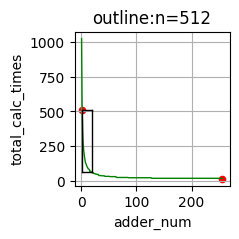

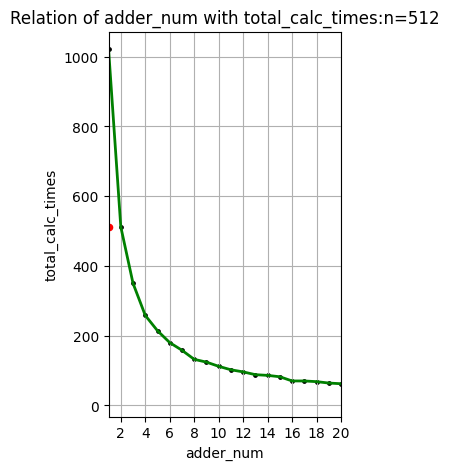

In [100]:
show_relation(n,result)

虽然增加加法器可以让时间复杂度从N降低到2*log2N  
但是可以从图中看到，n=512时，增加adder数量是边际效益递减的
- 当加法器数量较少时，增加加法器数量，时间复杂度急剧降低
- 当加法器数量较多时，再增加加法器带来的时间复杂度降低程度并不显著  
10个加法器就可以让总周期降低到**112**，看起来是不错的选择  
这就是我们在串行和并行方案中，兼顾硬件低功耗和性能做出的**权衡**，**可以在不增加大量硬件资源的情况下显著提升性能**

# 2.双前缀和(two prefix sums)的并行化

我们在上一节中已经见识到了，使用并行扫描算法，对单前缀和问题，进行并行化加速

那么对于
$$
x_t = a_t \cdot x_{t-1} + b_t \ \ \ \ (x_0 = b_0)
$$
即
```shell
#input
[(,b0),(a1,b1),(a2,b2),(a3,b3)...,(an,bn)]

#output
[x0,x1,x2,x3...,xn]
```
这是一个**双前缀和**序列的并行化问题，我们考虑将其转换为上一节中的，**单前缀和**序列的并行化问题

## 2.1 顺序计算

In [102]:
def inclusive_scan_recursive_2prefix(lst_i):
    n = len(lst_i)
    lst_o = []
    lst_o.append(lst_i[0][1])
    for i in range(1,n):
        lst_o[i] = lst_i[i][0]*lst_o[i-1] + lst_i[i][1]
    return lst_o

如果我们把乘法和加法看做一个周期内完成，则
- 需要时间为：`n-1`
- 需要计算次数为：加法`n-1`次，乘法`n-1`次
- 需要的资源为：加法器`1`个，乘法器`1`个

## 2.2 并行扫描

`Efficient Parallelization of a Ubiquitous Sequential Computation`  
的结论是
$$
log\ x_t = a_t^* + log(x_0 + b_t^*)
$$
其中
$$
a_t^*\ =\ \sum_tlog\ a_t
$$
$$
b_t^*\ =\ \sum_te^{logb_t-a_t^*}
$$
所以我们要求序列$x_t$，只需要求出序列$a_t^*和b_t^*$即可  
而$a_t^*$是求和序列，可以直接用并行扫描    
$a_t^*$计算完毕之后，$b_t^*$也可以转换为求和序列，问题就迎刃而解了  
下图给出计算的顺序

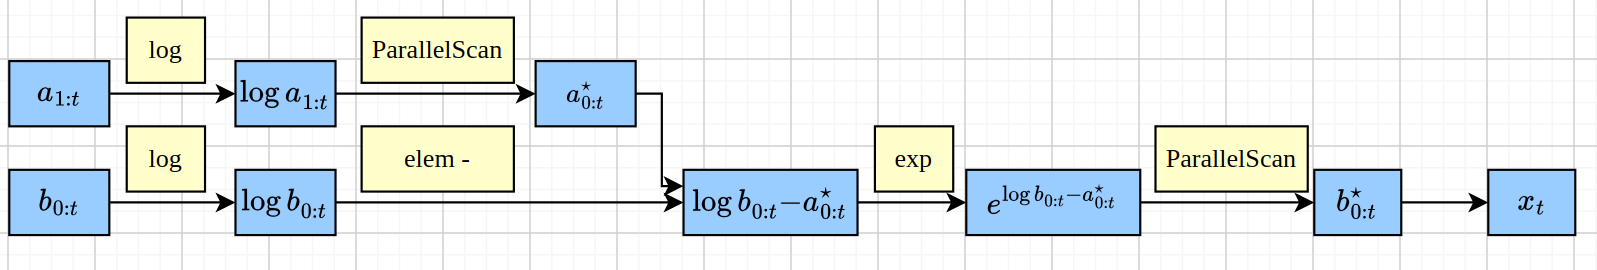
需要注意padding的问题（即没有a0），在`Were RNNs All We Needed?`的代码附录中可以参考

可以评估一下这个算法的指标(**又新引入了element wise log和element wise exp、element wise minus等**)   
<font color=red font size = 5>**注意**</font>
```c
if
```
element wize运算无法全并行同时运算 ->  **那么,光element wise log就consume n时间，此算法就没有时间优越性**
```c
else
```
element wize运算可以接近全并行同时运算 -> **那么，就需要n个log单元或者n/2个log单元，带来的复杂度远大于乘法加法单元**

# 算法验证

为了确保我们的理解无误，我们 **(1)** 先使用传统方法对问题进行求解，**(2)** 再使用上图提到的算法结合并行扫描实现，**(3)** 并比对结果
```shell
#input
[(,b0),(a1,b1),(a2,b2),(a3,b3)...,(an,bn)]

#output
[x0,x1,x2,x3...,xn]
```
首先给出并行扫描的函数实现

In [ ]:
import random
def blelloch_scan(arr):
        
    arr = list(arr)
    n = len(arr)

    print("Initial array:", arr)

    step = 1
    print("\nUpsweep Phase:")
    while step < n:
        for i in range(0, n, 2 * step):
            if i + step < n:
                arr[i + 2 * step - 1] += arr[i + step - 1]
        print(f"After step size {step}, array: {arr}")
        step *= 2

    arr[-1] = 0
    print("\nSetting root to 0, array:", arr)

    step = n // 2
    print("\nDownsweep Phase:")
    while step > 0:
        for i in range(0, n, 2 * step):
            if i + step < n:
                temp = arr[i + step - 1]
                arr[i + step - 1] = arr[i + 2 * step - 1]
                arr[i + 2 * step - 1] += temp
        print(f"After step size {step}, array: {arr}")
        step //= 2
        
        
    return arr

input_array = [random.randint(0,10) for _ in range(16)]
arr = blelloch_scan(input_array)
prefix_sum_array = [input_array[i] + arr[i] for i in range(len(input_array))]

print(f"\nFinal PrefixSum array: {prefix_sum_array}")